In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

## Reading in data and a scoring function

In [43]:
life = pd.read_csv('Life_Expectancy_Data.csv')
life.rename(inplace=True, columns={'Life expectancy ':'Life Expectancy','infant deaths':'Infant Deaths','percentage expenditure':'Percentage Expenditure','Measles ':'Measles',' BMI ':'BMI','under-five deaths ':'Under 5 Deaths','Diphtheria ':'Diptheria',' HIV/AIDS':'HIV/AIDS',' thinness  1-19 years':'Thinness 1-19 year','Income composition of resources':'Income Comp'})
life['constant'] = 1

In [31]:
sd = 8.796834
def my_score(y_test,y_pred,sd=9.3):
    diff = np.abs(y_pred-y_test)
    true = diff[diff<sd/2]
    return len(true)/len(y_test)

## Cleaning functions

In [ ]:
def replace(group, stds):
    group[np.abs(group - group.mean()) > stds * group.std()] = np.nan
    return group

# df is your DataFrame
col = life.columns.drop('Country')
col = col.drop('Status')
life.at[:, col] = life.groupby('Country').transform(lambda g: replace(g, 3))

In [13]:
def clean_na(df):
    col = df.columns
    col = col.drop('Country')
    # get unique countries
    countries = df.Country.unique()
    for country in countries:
        cur_country = df[df.Country==country]
        ind = cur_country.index
        for c in col:
            na_ind = cur_country[cur_country[c].isna()].index
            # proceed with calculations if there are any na values
            if len(na_ind) > 0:
                value_ind = [i for i in ind if i not in na_ind]
                for i in na_ind:
                    # if there is a value in that country in the year before and the year after
                    # fill it with the average between those two
                    if i-1 in value_ind and i+1 in value_ind:
                        df.at[i,c] = np.mean(df.loc[[i-1,i+1],c])
                        # if it is the first or last year, or surrounded by na, just take average of whole column
                    else:
                        df.at[i,c] = np.mean(df.loc[value_ind,c])
    return df

In [14]:
def clean_na_col(df):
    col = df.columns
    col = col.drop('Country')
    # get unique countries
    countries = df.Country.unique()
    for country in countries:
        cur_country = df[df.Country==country]
        ind = cur_country.index
        for c in col:
            na_ind = cur_country[cur_country[c].isna()].index
            # proceed with calculations if there are any na values
            if len(na_ind) > 0:
                value_ind = [i for i in ind if i not in na_ind]
                if len(value_ind) == 0:
                    # developing or developed
                    status = list(cur_country.Status)[0]
                    same_status = df[df.Status==status]
                    # get each year
                    for i in na_ind:
                        year = df.loc[i].Year
                        # find average for respective status and year
                        year_status = same_status[same_status["Year"] == year]
                        df.at[i,c] = np.mean(year_status[c])
    return df

## Random Forest Regressor

In [44]:
# no filling only mark missing
rf_data = clean_na(life)
for col in rf_data.columns:
    if rf_data[col].dtype is object:
        rf_data.fillna('missing',inplace=True)
    else:
        rf_data.fillna(-1,inplace=True)
        


rf_data= pd.get_dummies(rf_data,columns=['Status'],drop_first=True)
# rf_data= pd.get_dummies(rf_data,columns=['Status','Country'],drop_first=True)
y = rf_data['Life Expectancy']
rf_data.drop(columns=['Country','Life Expectancy'],inplace=True)

In [45]:
estims = [100,200,300]
feats = [5,10,15,20]
leaf = [7,10,15]

best_score = -1
best_n = -1
best_f = -1
lest_l = -1

for l in leaf:
    for n in estims:
        for f in feats:
            rf = RFR(n_estimators=n,max_depth=6,max_features=f,oob_score=True,warm_start=False)
            rf.fit(rf_data.values,y)

            if rf.oob_score_ > best_score:
                best_score = rf.oob_score_
                best_n = n
                best_f = f
                best_l = l

print(f'Maximal oob score was {best_score} with {best_n} estimators, max features {best_f}, and max depth of {6}')

Maximal oob score was 0.9435080563085168 with 200 estimators, max features 15, and max depth of 6


In [326]:
headers = rf_data.columns
best = RFR(max_depth=best_d,n_estimators=best_n,max_features=best_f,oob_score=True,warm_start=False)
best.fit(rf_data,y)
imp = np.argsort(best.feature_importances_)
small = imp[:5]
big = imp[-5:]
print(f'Least important features: {list(headers[small])}')
print(f'Most important features: {list(headers[big])}')

Least important features: ['constant', 'Status_Developing', 'Measles', 'Population', 'Percentage Expenditure']
Most important features: ['Alcohol', 'BMI', 'Income Comp', 'Adult Mortality', 'HIV/AIDS']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [319]:
headers[imp]

Index(['constant', 'Status_Developing', 'Population', 'Percentage Expenditure',
       'Measles', 'GDP', 'Hepatitis B', 'Total expenditure', 'Diptheria',
       'Polio', 'Infant Deaths', 'Year', 'Thinness 1-19 year',
       'Under 5 Deaths', ' thinness 5-9 years', 'Alcohol', 'Schooling', 'BMI',
       'Income Comp', 'Adult Mortality', 'HIV/AIDS'],
      dtype='object')

In [29]:
best = RFR(max_depth=6,max_features=f,n_estimators=best_n,oob_score=True,warm_start=False)
best.fit(rf_data,y)
best.oob_score_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


0.9428329274663965

In [46]:
sd = []
oob = []
r = []
MSEs = []
MAEs = []
for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(rf_data,y,test_size=.3)
    X = X_test
    y_test = np.array(y_test)
    best = RFR(max_depth=6,max_features=f,n_estimators=best_n,oob_score=True,warm_start=False)
    best.fit(X_train.values,y_train)
    pred = best.predict(X_test.values)
    sd.append(my_score(y_test,pred))
    oob.append(best.oob_score_)
    r.append(best.score(X_test.values,y_test))
    
    MSEs.append(mse(y_test,pred))
    MAEs.append(mae(y_test,pred))
    
print(f'Mean squared error: {np.mean(MSEs)} \nMean absolute error: {np.mean(MAEs)} \nMy score: {np.mean(my_scores)}')
print(np.mean(sd),np.mean(oob),np.mean(r))

Mean squared error: 6.3794149281624435 
Mean absolute error: 1.7625606229835866 
My score: 0.46394557823129245
0.9325963718820863 0.9395050760488212 0.9395421772089222


Mean squared error: 6.688014734990532 
Mean absolute error: 1.7807504042777833 
My score: 0.46394557823129245
0.9283333333333335 0.9385146660162355 0.9375861586636144

In [42]:
print(f'Mean squared error: {np.mean(MSEs)} \nMean absolute error: {np.mean(MAEs)}')
print('R^2 score: ',np.mean(r))

Mean squared error: 6.688014734990532 
Mean absolute error: 1.7807504042777833
R^2 score:  0.9375861586636144


test for scoring

In [27]:
MSEs = []
MAEs = []
oob_scores = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(rf_data,y,test_size=.3)
    X = X_test
    y_test = np.array(y_test)
    
    for __ in range(10):
        best = RFR(max_depth=6,max_features=f,n_estimators=best_n,oob_score=True,warm_start=False)
        best.fit(X_train,y_train)
        oob_scores.append(best.oob_score_)

        actual = y_test
        rf_pred = best.predict(X)
        MSEs.append(mse(y_test,rf_pred))
        MAEs.append(mae(y_test,rf_pred))
print(f'Mean squared error: {np.mean(MSEs)} \nMean absolute error: {np.mean(MAEs)} \nMy score: {np.mean(my_scores)}')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: 

Mean squared error: 6.240073875829744 
Mean absolute error: 1.7691528506763503 
My score: 0.46394557823129245


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


0.9520398437992653
5.100681479692573
1.5437887407386715


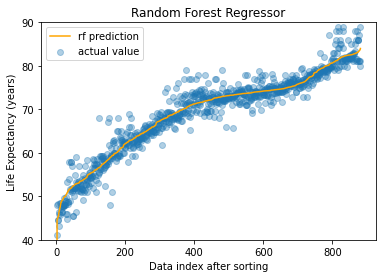

In [346]:
X_train, X_test, y_train, y_test = train_test_split(rf_data,y,test_size=.3)

best = RFR(max_depth=8,n_estimators=best_n,oob_score=True,warm_start=False)
best.fit(X_train,y_train)
print(best.oob_score_)

X = X_test
y_test = np.array(y_test)

actual = y_test
rf_pred = best.predict(X)
print(mse(y_test,rf_pred))
print(mae(y_test,rf_pred))

sort = np.argsort(rf_pred)
N = len(rf_pred)

actual = actual[sort]
rf_pred  = rf_pred[sort]

np.save('actual.npy',actual)
np.save('rf_pred.npy',rf_pred)

plt.scatter(np.arange(N),actual,label='actual value',alpha=0.35, zorder=1)
plt.plot(np.arange(N),rf_pred,label='rf prediction', color='orange',alpha=1,zorder=2)

plt.legend(loc='upper left')
plt.ylim(40,90)
plt.xlabel('Data index after sorting')
plt.ylabel('Life Expectancy (years)')
plt.title("Random Forest Regressor")
plt.savefig('rf.pdf',bbox_inches='tight',pad_inches=0.25)
plt.show()

In [242]:
rf_gs.best_estimator_
pred = rf_gs.predict(X_test)
score = my_score(y_test,pred)
er1 = mse(y_test,pred)
er2 = mae(y_test,pred)
print(f'Mean squared error: {er1} \nMean absolute error: {er2} \nMy score: {score}')

Mean squared error: 21.218734998437885 
Mean absolute error: 2.20009136425916 
My score: 0.8900226757369615


In [254]:
# fill what makes sense to and then add missing
rf_data = clean_na(life)

for col in rf_data.columns:
    if rf_data[col].dtype is object:
        rf_data.fillna('missing',inplace=True)
    else:
        rf_data.fillna(-1,inplace=True)
       
    
rf_data= pd.get_dummies(rf_data,columns=['Status','Country'],drop_first=True)

y = rf_data['Life Expectancy']
X_train, X_test, y_train, y_test = train_test_split(rf_data.drop(columns=['Life Expectancy']),y,test_size=.3)

In [235]:
rf = RandomForestRegressor()
param_grid = {"max_depth": [4,6,8],"n_estimators":[50,100,200],"min_samples_leaf": [5,10,20],"max_leaf_nodes":[10,20]}
rf_gs = GridSearchCV(rf, param_grid, n_jobs=-1)
rf_gs.fit(X_train, y_train)
rf_gs.score(X_test,y_test)

0.9220934497365059

In [243]:
rf_gs.best_estimator_
pred = rf_gs.predict(X_test)
score = my_score(y_test,pred)

er1 = mse(y_test,pred)
er2 = mae(y_test,pred)
print(f'Mean squared error: {er1} \nMean absolute error: {er2} \nMy score: {score}')

Mean squared error: 21.218734998437885 
Mean absolute error: 2.20009136425916 
My score: 0.8900226757369615


In [257]:
rf_gs.best_estimator_

RandomForestRegressor(max_depth=6, max_leaf_nodes=20, min_samples_leaf=5)

wow look! cleaning reduced MSE from 14.7 to 9.84

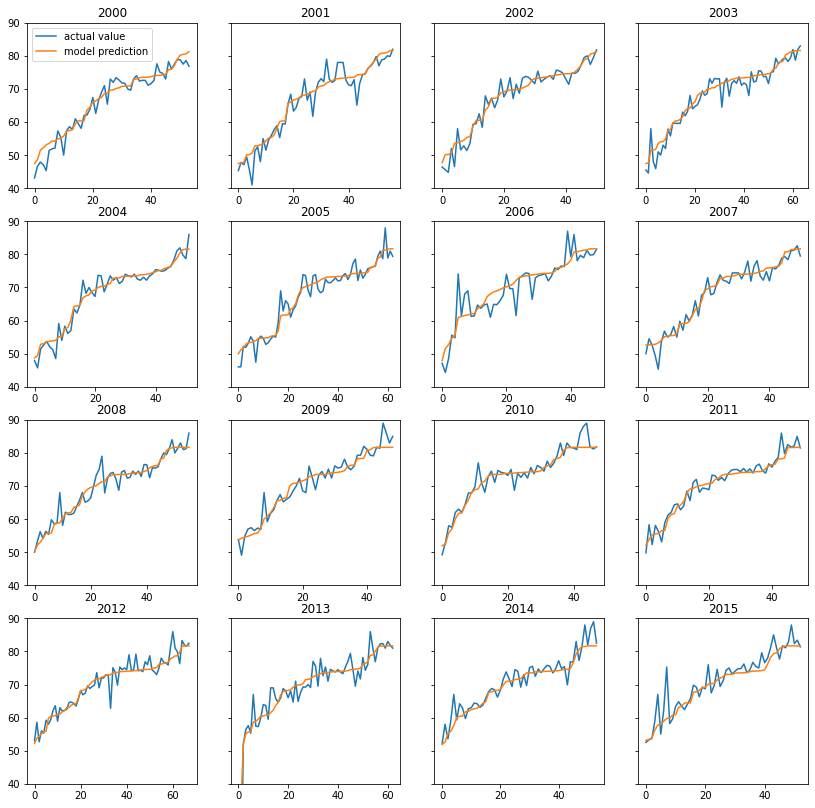

In [190]:
fig, axs = plt.subplots(4, 4,figsize=(14,14),sharey=True)
ax = axs.ravel()

for i,year in enumerate(np.unique(life['Year'])):
    d_year = rf_data[rf_data['Year']==year]
    
    idx = np.where(X_test["Year"]==year)
    X = X_test[X_test["Year"]==year]
    y = np.array(y_test)
    
    actual_year = y[idx[0]]
    pred_year = rf_gs.predict(X)

    sort = np.argsort(pred_year)
    N = len(pred_year)
    ax[i].scatter(np.arange(N),actual_year[sort],label='actual value')
    ax[i].plot(np.arange(N),pred_year[sort],label='model prediction')
    ax[i].set_title(str(year))

ax[0].legend(loc='upper left')
plt.ylim(40,90)
plt.show()

In [8]:
life = pd.read_csv('Life_Expectancy_Data.csv')
life.rename(inplace=True, columns={'Life expectancy ':'Life Expectancy','infant deaths':'Infant Deaths','percentage expenditure':'Percentage Expenditure','Measles ':'Measles',' BMI ':'BMI','under-five deaths ':'Under 5 Deaths','Diphtheria ':'Diptheria',' HIV/AIDS':'HIV/AIDS',' thinness  1-19 years':'Thinness 1-19 year','Income composition of resources':'Income Comp'})
life['constant'] = 1

In [9]:
# fill in columns now
life = clean_na(life)
life = clean_na_col(life)

# making categories
life['age bin'] = 40.
ages = [45.,50.,55.,60.,65.,70.,75.,80.,85.]
for age in ages:
    mask = life['Life Expectancy'] >= age
    life.loc[mask,'age bin'] = age
y = life['age bin']

life = pd.get_dummies(life,columns=['Status','Country'],drop_first=True)
y = life['age bin']

X_train, X_test, y_train, y_test = train_test_split(life.drop(columns=['Life Expectancy','age bin']),y,test_size=.3)

## Naive Bayes

In [10]:
MSEs = []
MAEs = []
my_scores = []
for _ in range(10):   
    X_train, X_test, y_train, y_test = train_test_split(life.drop(columns=['Life Expectancy','age bin']),y,test_size=.3)
    nb = GaussianNB()
    nb.fit(X_train,y_train)
    pred = nb.predict(X_test)

    correct = pred[pred==y_test]
    score = len(correct)/len(y_test)

    MSEs.append(mse(y_test,pred))
    MAEs.append(mae(y_test,pred))
    my_scores.append(score)
print(f'Mean squared error: {np.mean(MSEs)} \nMean absolute error: {np.mean(MAEs)} \nMy score: {np.mean(my_scores)}')

Mean squared error: 91.2046485260771 
Mean absolute error: 6.963151927437641 
My score: 0.2964852607709751


## QDA

In [11]:
MSEs = []
MAEs = []
my_scores = []
for _ in range(10):   
    X_train, X_test, y_train, y_test = train_test_split(life.drop(columns=['Life Expectancy','age bin']),y,test_size=.3)
    qda = QDA()
    qda.fit(X_train,y_train)
    pred = qda.predict(X_test)

    correct = pred[pred==y_test]
    score = len(correct)/len(y_test)

    MSEs.append(mse(y_test,pred))
    MAEs.append(mae(y_test,pred))
    my_scores.append(score)
print(f'Mean squared error: {np.mean(MSEs)} \nMean absolute error: {np.mean(MAEs)} \nMy score: {np.mean(my_scores)}')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/

Mean squared error: 45.666099773242635 
Mean absolute error: 4.0935374149659856 
My score: 0.46394557823129245


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


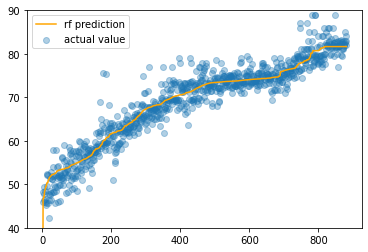

In [261]:
d_year = rf_data[rf_data['Year']==year]

idx = np.where(X_test["Year"]==year)
X = X_test
y = np.array(y_test)

actual = y
rf_pred = rf_gs.predict(X)

sort = np.argsort(rf_pred)
N = len(rf_pred)

actual = actual[sort]
rf_pred  = rf_pred[sort]

np.save('actual.npy',actual)
np.save('rf_pred.npy',rf_pred)

plt.scatter(np.arange(N),actual,label='actual value',alpha=0.35, zorder=1)
plt.plot(np.arange(N),rf_pred,label='rf prediction', color='orange',alpha=1,zorder=2)

plt.legend(loc='upper left')
plt.ylim(40,90)
plt.show()